In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
#import seaborn as sb
import numpy as np
from ISLP import load_data

In [2]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence \
     import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)

In [3]:
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [30]:
Bike = load_data('Bikeshare')

In [31]:
#####poisson
Y = Bike['bikers']
hr_encode = contrast('hr', 'sum')
mnth_encode = contrast('mnth', 'sum')
X2 = MS([mnth_encode,
         hr_encode,
        'workingday',
        'temp',
        'weathersit']).fit_transform(Bike)

In [32]:
#####poisson
M_pois = sm.GLM(Y, X2, family=sm.families.Poisson()).fit()

In [33]:
#### računa koeficijente za 23. sat i 12. mjesec
S_pois = summarize(M_pois)
coef_month = S_pois[S_pois.index.str.contains('mnth')]['coef']
coef_month = pd.concat([coef_month,
                        pd.Series([-coef_month.sum()],
                                   index=['mnth[Dec]'])])
coef_hr = S_pois[S_pois.index.str.contains('hr')]['coef']
coef_hr = pd.concat([coef_hr,
                     pd.Series([-coef_hr.sum()],
                     index=['hr[23]'])])

In [34]:
# Funkcija koja će napraviti mali jitter u x-smjeru, kao u knjizi

JITTER = 0.2 # jačina Jitter efekta

def jitter(a):
    
    a = a.reset_index(drop=True).astype('float')
    
    for j in range(0,len(a)):
        a[j] = a[j] + round(random.uniform(-JITTER, JITTER),2)
        
    return a

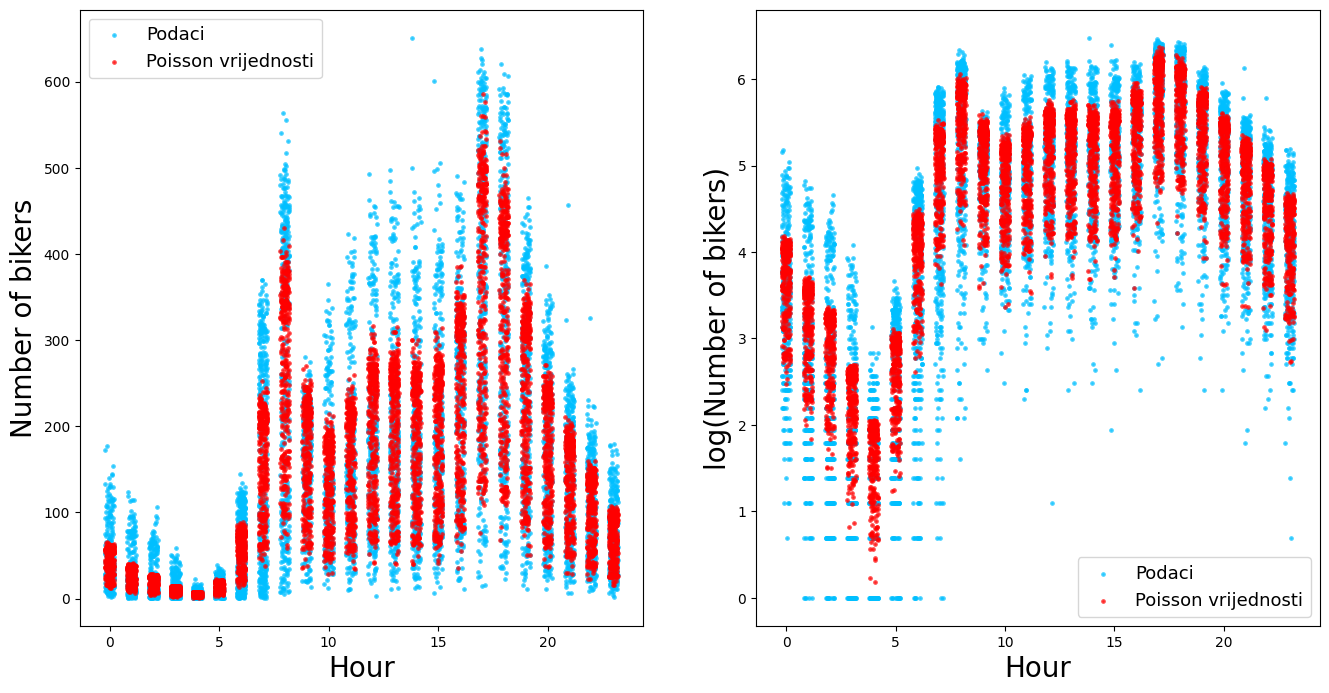

In [35]:
fig_pois, (ax_number, ax_lognumber) = plt.subplots(1, 2, figsize=(16,8))

x_hr = np.arange(coef_hr.shape[0])
for i in x_hr:
    
    Bikers_hour = Bike['hr'] == i ##Sortira samo za jedan sat
    
    Number_of_bikers = Bike[Bikers_hour]['bikers'] ##Svi zapisani brojevi bikera za taj sat
    Poisson_values = M_pois.fittedvalues.reindex_like(Number_of_bikers) ##Poisson vrijednosti bikera za taj sat

    
    hour = Bike[Bikers_hour]['hr']  ##Uzima array za određeni sat
    hour = jitter(hour) # proizvodi jitter
    
    ax_number.scatter(hour , Number_of_bikers, color='deepskyblue', linewidth=2, s=2, alpha=.7)
    ax_number.scatter(hour , Poisson_values, color='red', linewidth=2, s=2, alpha=.7)

    ax_lognumber.scatter(hour , np.log(Number_of_bikers), color='deepskyblue', linewidth=2, s=2, alpha=.7)
    ax_lognumber.scatter(hour , np.log(Poisson_values), color='red', linewidth=2, s=2, alpha=.7)


    
ax_number.set_xlabel('Hour', fontsize=20)
ax_number.set_ylabel('Number of bikers', fontsize=20);

ax_lognumber.set_xlabel('Hour', fontsize=20)
ax_lognumber.set_ylabel('log(Number of bikers)', fontsize=20);

ax_number.legend(['Podaci', 'Poisson vrijednosti'],loc='upper left', frameon=True,fontsize=13)
ax_lognumber.legend(['Podaci', 'Poisson vrijednosti'],loc='lower right', frameon=True,fontsize=13)